# Inference
In this notebook, we will use the fine-tuned LayoutLM model on SROIE to do inference on a random receipt image that we downloaded
[here](https://www.google.com/imgres?imgurl=https%3A%2F%2Fwww.inogic.com%2Fblog%2Fwp-content%2Fuploads%2F2020%2F09%2FReceipt-Processor-AI-Builder-in-Canvas-App-9.png&imgrefurl=https%3A%2F%2Fwww.inogic.com%2Fblog%2F2020%2F09%2Fhow-to-use-receipt-processor-ai-builder-in-canvas-app%2F&tbnid=qcwh-JNsqwexXM&vet=12ahUKEwjHys758qr0AhVMR_UHHS5WD1oQMygUegUIARD9AQ..i&docid=lU1wf51-i3jyNM&w=277&h=398&q=receipt&ved=2ahUKEwjHys758qr0AhVMR_UHHS5WD1oQMygUegUIARD9AQ)

In [1]:
!which python

~/.config/miniconda3/envs/layoutlm/bin/python


In [2]:
import os
import glob
import json 
import random
from pathlib import Path
from difflib import SequenceMatcher

import cv2
import pandas as pd
import numpy as np
from PIL import Image
from tqdm.notebook import tqdm
from IPython.display import display
import matplotlib
from matplotlib import pyplot, patches

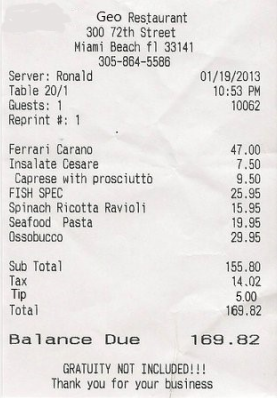

In [3]:
path_image = Path("Receipt-Processor-AI-Builder-in-Canvas-App-9.png")
image = Image.open(path_image)
exif = image._getexif()
orientation_key = 274
if exif and exif.get(orientation_key):
    image = exif_transpose(image)
image

In [4]:
import pytesseract
#df = pytesseract.image_to_data(image, lang="jpn_vert", output_type="data.frame")
df = pytesseract.image_to_data(image, output_type="data.frame")
df

,level,page_num,block_num,par_num,line_num,word_num,left,top,width,height,conf,text
0,1,1,0,0,0,0,0,0,277,398,-1,NaN
1,2,1,1,0,0,0,75,11,117,41,-1,NaN
2,3,1,1,1,0,0,75,11,117,41,-1,NaN
3,4,1,1,1,1,0,97,11,90,12,-1,NaN
4,5,1,1,1,1,1,97,11,25,11,94,Geo
...,...,...,...,...,...,...,...,...,...,...,...,...
91,5,1,3,1,2,1,52,378,29,11,96,Thank
92,5,1,3,1,2,2,87,380,18,10,95,you
93,5,1,3,1,2,3,112,378,17,11,95,for
94,5,1,3,1,2,4,135,381,24,9,95,your


In [5]:
df_nona = df.dropna()
df_nona

,level,page_num,block_num,par_num,line_num,word_num,left,top,width,height,conf,text
4,5,1,1,1,1,1,97,11,25,11,94,Geo
5,5,1,1,1,1,2,128,12,59,11,79,Restaurant
7,5,1,1,1,2,1,87,27,17,10,90,300
8,5,1,1,1,2,2,111,27,23,10,96,72th
9,5,1,1,1,2,3,141,27,34,11,90,Street
...,...,...,...,...,...,...,...,...,...,...,...,...
91,5,1,3,1,2,1,52,378,29,11,96,Thank
92,5,1,3,1,2,2,87,380,18,10,95,you
93,5,1,3,1,2,3,112,378,17,11,95,for
94,5,1,3,1,2,4,135,381,24,9,95,your


In [6]:
df_nona = df_nona.assign(
    bottom = lambda x: x.top + x.height,
    right = lambda x: x.left + x.width,
)
df_nona.head()

,level,page_num,block_num,par_num,line_num,word_num,left,top,width,height,conf,text,bottom,right
4,5,1,1,1,1,1,97,11,25,11,94,Geo,22,122
5,5,1,1,1,1,2,128,12,59,11,79,Restaurant,23,187
7,5,1,1,1,2,1,87,27,17,10,90,300,37,104
8,5,1,1,1,2,2,111,27,23,10,96,72th,37,134
9,5,1,1,1,2,3,141,27,34,11,90,Street,38,175


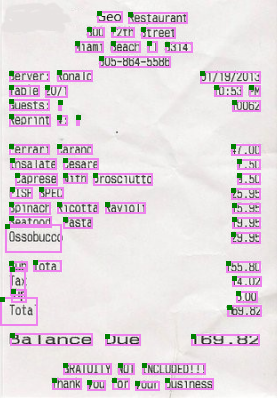

In [7]:
from PIL import ImageDraw
from itertools import product

draw = ImageDraw.Draw(image)

for row in df_nona.itertuples():
    bbox = [row.left, row.top, row.right, row.bottom]
    draw.rectangle(
        bbox,
        outline="violet",
        width=2,
    )

    # naive
    #draw.point([(row.left, row.top)], fill="green")

    # more sophisticated
    n_px = 5
    draw.point(
        [(row.left+i, row.top+j) for i, j in product(range(n_px), range(n_px))],
        fill="green",
    )

image

In [8]:
image.size

(277, 398)

In [9]:
from PIL import ImageColor, ImageDraw, ImageFont

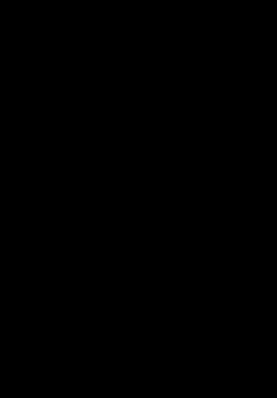

In [10]:
w, h = image.size
Image.new("RGB", [w, h], color=ImageColor.colormap["black"])

In [11]:
def ocr_viz(image, df):
    w, h = image.size
    viz = Image.new("RGB", [w, h], color=ImageColor.colormap["black"])
    draw = ImageDraw.Draw(viz)
    font = ImageFont.truetype("/usr/share/fonts/dejavu-serif-fonts/DejaVuSerif.ttf", 10)
    for row in df.itertuples():
        text = row.text
        left = row.left
        top = row.top
        draw.text([left, top], text, font=font)
    return viz

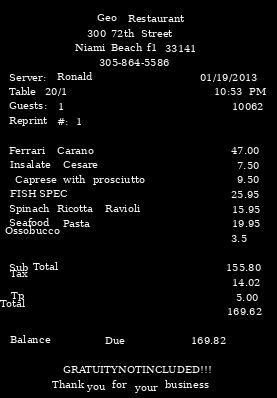

In [12]:
ocr_viz(image, df_nona)

Remember we have generated the files `test_box.txt`, `test_image.txt`, `test.txt`? Have you wondered what exactly they
contain?

- `test_box.txt` contains the tokens texts and their corresponding bbox coordinates. **Caveat**: The coordinates here
  have already been **normalized** -- Remember that we have the normalization step that makes the image's width and
  height both `1000px`?
- `test_image.txt` contains the bbox coordinates, image width and height, and image filename. The coordinates here
  are the original, untouched ones.
- `test.txt` contains the ground truth BIOES tags.

## Load and Run LayoutLM Model

In [13]:
import torch
from torch.nn import CrossEntropyLoss

from transformers import (
    WEIGHTS_NAME,
    AdamW,
    BertConfig,
    BertForTokenClassification,
    BertTokenizer,
    get_linear_schedule_with_warmup,
)
from layoutlm import (
    FunsdDataset,
    LayoutlmConfig,
    LayoutlmForTokenClassification
)

In [14]:
config_class, model_class, tokenizer_class = \
    LayoutlmConfig, LayoutlmForTokenClassification, BertTokenizer

In [15]:
do_lower_case = True
output_dir = Path.home() / "git-repos/github/microsoft/unilm/layoutlm/deprecated/examples/seq_labeling/output"
model_name_or_path = Path("layoutlm-base-uncased")#.absolute()
model_name_or_path.exists(), output_dir.exists()

(True, True)

In [16]:
tokenizer = tokenizer_class.from_pretrained(
    str(model_name_or_path), do_lower_case=do_lower_case
)
model = model_class.from_pretrained(str(output_dir))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model

LayoutlmForTokenClassification(
  (bert): LayoutlmModel(
    (embeddings): LayoutlmEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (x_position_embeddings): Embedding(1024, 768)
      (y_position_embeddings): Embedding(1024, 768)
      (h_position_embeddings): Embedding(1024, 768)
      (w_position_embeddings): Embedding(1024, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Drop

From the previous cell's output, we see
```
(classifier): Linear(in_features=768, out_features=5, bias=True)
```
`out_features=5` means the five tags (in `labels.txt`)

- `S-COMPANY`
- `S-DATE`
- `S-ADDRESS`
- `S-TOTAL`
- `O`

In [17]:
pad_token_label_id = CrossEntropyLoss().ignore_index
pad_token_label_id

-100

In [18]:
isinstance(image, Image.Image)

True

In [19]:
image.filename

'/home/phunc20/git-repos/phunc20/python/layoutlm/sroie/urbikn/Receipt-Processor-AI-Builder-in-Canvas-App-9.png'

In [20]:
def normalize(points: list, width: int, height: int) -> list:
    x0, y0, x2, y2 = [int(p) for p in points]
    x0 = int(1000 * (x0 / width))
    x2 = int(1000 * (x2 / width))
    y0 = int(1000 * (y0 / height))
    y2 = int(1000 * (y2 / height))

    return [x0, y0, x2, y2]


def write_dataset(image: Image.Image, df: pd.DataFrame, output_dir: Path, name: str):
    print(f"Writing {name}ing dataset:")
    with open(output_dir / f"{name}.txt", "w+", encoding="utf8") as file, \
         open(output_dir / f"{name}_box.txt", "w+", encoding="utf8") as file_bbox, \
         open(output_dir / f"{name}_image.txt", "w+", encoding="utf8") as file_image:

        width, height = image.size
        filename = image.filename
        for index, row in df.iterrows():
            bbox = [int(p) for p in row[["left", "top", "right", "bottom"]]]
            normalized_bbox = normalize(bbox, width, height)

            file.write("{}\t{}\n".format(row['text'], "O"))  # we don't actually have labels so put all O's
            #file.write("{}\t{}\n".format(row['text'], "S-COMPANY"))
            file_bbox.write("{}\t{} {} {} {}\n".format(row['text'], *normalized_bbox))
            file_image.write("{}\t{} {} {} {}\t{} {}\t{}\n".format(row['text'], *bbox, width, height, filename))

        # Write a second newline to separate dataset from others
        file.write("\n")
        file_bbox.write("\n")
        file_image.write("\n")

In [21]:
old_dir = Path.cwd()
pretrained_model_folder = old_dir / 'layoutlm-base-uncased/'
label_file = old_dir / "dataset/labels.txt"
old_dir, pretrained_model_folder, label_file

(PosixPath('/home/phunc20/git-repos/phunc20/python/layoutlm/sroie/urbikn'),
 PosixPath('/home/phunc20/git-repos/phunc20/python/layoutlm/sroie/urbikn/layoutlm-base-uncased'),
 PosixPath('/home/phunc20/git-repos/phunc20/python/layoutlm/sroie/urbikn/dataset/labels.txt'))

In [22]:
#os.chdir(old_dir)
write_dataset(image, df_nona, Path("dataset"), "infer")
#write_dataset(image, df_nona, Path("dataset"), "test")

Writing infering dataset:


In [23]:
# Move to the unilm directory
unilm = Path.home() / "git-repos/github/microsoft/unilm/layoutlm/deprecated/"
#os.chdir(unilm / "examples/seq_labeling")

## Infer Directly, Not via Python Script


In [24]:
def get_labels(path):
    with open(path, "r") as f:
        labels = f.read().splitlines()
    if "O" not in labels:
        labels = ["O"] + labels
    return labels

labels = get_labels(Path("dataset/labels.txt"))
labels

['S-COMPANY', 'S-DATE', 'S-ADDRESS', 'S-TOTAL', 'O']

In [25]:
from layoutlm.data.funsd import (
    read_examples_from_file,
    convert_examples_to_features,
)

In [26]:
data_dir = old_dir / "dataset"
mode = "infer"
examples = read_examples_from_file(data_dir, mode)
examples

In [27]:
type(examples), len(examples)

(list, 1)

In [28]:
def non_dunders(obj):
    return [s for s in dir(obj) if not s.startswith("_")]

In [29]:
non_dunders(examples[0])

['actual_bboxes', 'boxes', 'file_name', 'guid', 'labels', 'page_size', 'words']

In [30]:
pad_token_label_id

-100

In [31]:
max_seq_length = 512
features = convert_examples_to_features(
    examples,
    labels,
    max_seq_length,
    tokenizer,
    cls_token_at_end=False,
    cls_token=tokenizer.cls_token,
    cls_token_segment_id=0,
    sep_token=tokenizer.sep_token,
    sep_token_extra=False,
    pad_on_left=False,
    pad_token=tokenizer.convert_tokens_to_ids([tokenizer.pad_token])[0],
    pad_token_segment_id=0,
    pad_token_label_id=pad_token_label_id,
)
features

In [32]:
non_dunders(features[0])

['actual_bboxes',
 'boxes',
 'file_name',
 'input_ids',
 'input_mask',
 'label_ids',
 'page_size',
 'segment_ids']

In [33]:
features[0].actual_bboxes[0], examples[0].actual_bboxes[0]

([0, 0, 277, 398], [97, 11, 122, 22])

In [34]:
all_input_ids = torch.tensor(
    [f.input_ids for f in features], dtype=torch.long
)
all_input_mask = torch.tensor(
    [f.input_mask for f in features], dtype=torch.long
)
all_segment_ids = torch.tensor(
    [f.segment_ids for f in features], dtype=torch.long
)
all_label_ids = torch.tensor(
    [f.label_ids for f in features], dtype=torch.long
)
all_bboxes = torch.tensor([f.boxes for f in features], dtype=torch.long)

In [35]:
print(f"all_input_ids.shape = {all_input_ids.shape}")
print(f"all_input_mask.shape = {all_input_mask.shape}")
print(f"all_segment_ids.shape = {all_segment_ids.shape}")
print(f"all_label_ids.shape = {all_label_ids.shape}")
print(f"all_bboxes.shape = {all_bboxes.shape}")

all_input_ids.shape = torch.Size([1, 512])
all_input_mask.shape = torch.Size([1, 512])
all_segment_ids.shape = torch.Size([1, 512])
all_label_ids.shape = torch.Size([1, 512])
all_bboxes.shape = torch.Size([1, 512, 4])


In [36]:
help(model.eval)

Help on method eval in module torch.nn.modules.module:

eval() -> ~T method of layoutlm.modeling.layoutlm.LayoutlmForTokenClassification instance
    Sets the module in evaluation mode.
    
    This has any effect only on certain modules. See documentations of
    particular modules for details of their behaviors in training/evaluation
    mode, if they are affected, e.g. :class:`Dropout`, :class:`BatchNorm`,
    etc.
    
    This is equivalent with :meth:`self.train(False) <torch.nn.Module.train>`.
    
    See :ref:`locally-disable-grad-doc` for a comparison between
    `.eval()` and several similar mechanisms that may be confused with it.
    
    Returns:
        Module: self



In [37]:
batch = (
    all_input_ids,
    all_input_mask,
    all_segment_ids,
    all_label_ids,
    all_bboxes,
)

In [38]:
with torch.no_grad():
    inputs = {
        "input_ids": batch[0].to(device),
        "attention_mask": batch[1].to(device),
        "labels": batch[3].to(device),
    }
    inputs["bbox"] = batch[4].to(device)
    inputs["token_type_ids"] = batch[2].to(device)
    outputs = model(**inputs)

outputs

(tensor(1.0539),
 tensor([[[-0.3346, -0.8998, -1.2502, -1.2798,  3.8457],
          [ 7.2287, -1.9548, -1.9493, -2.0782, -1.1399],
          [ 7.2077, -2.2209, -1.8718, -2.2939, -0.8219],
          ...,
          [-2.2399, -2.4258, -1.9603, -2.4760,  8.5894],
          [-2.3741, -2.3402, -1.7506, -2.5040,  8.6069],
          [-2.0501, -2.2835, -2.0357, -2.4545,  8.3815]]]))

In [39]:
tmp_eval_loss, logits = outputs[:2]
tmp_eval_loss

tensor(1.0539)

In [40]:
logits.shape

torch.Size([1, 512, 5])

In [41]:
preds = logits.detach().cpu().numpy()
out_label_ids = inputs["labels"].detach().cpu().numpy()

In [42]:
preds.shape, out_label_ids.shape

((1, 512, 5), (1, 512))

In [43]:
preds

array([[[-0.33458513, -0.8998427 , -1.2502475 , -1.2798413 ,
          3.845738  ],
        [ 7.228703  , -1.9547551 , -1.9493343 , -2.078216  ,
         -1.139866  ],
        [ 7.2077036 , -2.220937  , -1.8718283 , -2.293869  ,
         -0.8218928 ],
        ...,
        [-2.2399247 , -2.4257796 , -1.9602679 , -2.4759588 ,
          8.589424  ],
        [-2.3741326 , -2.3401606 , -1.7506081 , -2.504021  ,
          8.606856  ],
        [-2.0501132 , -2.2834904 , -2.0356505 , -2.454518  ,
          8.381524  ]]], dtype=float32)

In [44]:
out_label_ids

array([[-100,    4,    4,    4,    4, -100,    4,    4, -100,    4,    4,
           4, -100,    4, -100, -100, -100, -100, -100, -100,    4, -100,
           4,    4, -100, -100, -100, -100,    4,    4, -100, -100,    4,
        -100, -100,    4,    4, -100,    4,    4, -100, -100,    4,    4,
        -100,    4,    4,    4, -100,    4, -100, -100,    4, -100, -100,
           4,    4, -100, -100,    4, -100, -100,    4,    4, -100, -100,
        -100,    4, -100, -100,    4,    4,    4, -100, -100,    4, -100,
           4, -100,    4, -100,    4, -100, -100,    4,    4,    4, -100,
        -100,    4, -100, -100, -100,    4, -100, -100,    4,    4,    4,
        -100, -100,    4,    4, -100, -100,    4, -100,    4, -100, -100,
           4,    4, -100, -100,    4,    4,    4, -100, -100,    4, -100,
        -100,    4,    4, -100, -100, -100,    4,    4,    4,    4,    4,
        -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
        -100, -100, -100, -100, -100, 

In [45]:
preds = np.argmax(preds, axis=2)
preds.shape

(1, 512)

In [46]:
preds

array([[4, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 1, 1, 1, 4, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 

In [47]:
label_map = {i: label for i, label in enumerate(labels)}
label_map

{0: 'S-COMPANY', 1: 'S-DATE', 2: 'S-ADDRESS', 3: 'S-TOTAL', 4: 'O'}

In [48]:
out_label_list = [[] for _ in range(out_label_ids.shape[0])]
preds_list = [[] for _ in range(out_label_ids.shape[0])]
                                                        
for i in range(out_label_ids.shape[0]):
    for j in range(out_label_ids.shape[1]):
        if out_label_ids[i, j] != pad_token_label_id:
            out_label_list[i].append(label_map[out_label_ids[i][j]])
            preds_list[i].append(label_map[preds[i][j]])

In [49]:
preds_list

[['S-COMPANY',
  'S-COMPANY',
  'S-ADDRESS',
  'S-ADDRESS',
  'S-ADDRESS',
  'S-ADDRESS',
  'S-ADDRESS',
  'S-ADDRESS',
  'S-ADDRESS',
  'O',
  'O',
  'O',
  'S-DATE',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'S-TOTAL',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O']]

In [50]:
" ".join(df_nona["text"])

'Geo Restaurant 300 72th Street Niami Beach f1 33141 305-864-5586 Server: Ronald 01/19/2013 Table 20/1 10:53 PM Guests: 1 10062 Reprint #: 1 Ferrari Carano 47.00 Insalate Cesare 7.50 Caprese with prosciutto 9.50 FISH SPEC 25.95 Spinach Ricotta Ravioli 15.95 Seafood Pasta 19.95 Ossobucco 3.5 Sub Total 155.80 Tax 14.02 Tp 5.00 Total 169.62 Balance Due 169.82 GRATUITY NOT INCLUDED!!! Thank you for your business'

In [51]:
df_nona["tag"] = preds_list[0]
df_nona

,level,page_num,block_num,par_num,line_num,word_num,left,top,width,height,conf,text,bottom,right,tag
4,5,1,1,1,1,1,97,11,25,11,94,Geo,22,122,S-COMPANY
5,5,1,1,1,1,2,128,12,59,11,79,Restaurant,23,187,S-COMPANY
7,5,1,1,1,2,1,87,27,17,10,90,300,37,104,S-ADDRESS
8,5,1,1,1,2,2,111,27,23,10,96,72th,37,134,S-ADDRESS
9,5,1,1,1,2,3,141,27,34,11,90,Street,38,175,S-ADDRESS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,5,1,3,1,2,1,52,378,29,11,96,Thank,389,81,O
92,5,1,3,1,2,2,87,380,18,10,95,you,390,105,O
93,5,1,3,1,2,3,112,378,17,11,95,for,389,129,O
94,5,1,3,1,2,4,135,381,24,9,95,your,390,159,O


In [52]:
labels

['S-COMPANY', 'S-DATE', 'S-ADDRESS', 'S-TOTAL', 'O']

In [53]:
" ".join(df_nona["text"][df_nona["tag"] == "S-COMPANY"])

'Geo Restaurant'

In [54]:
[" ".join(df_nona["text"][df_nona["tag"] == tag]) for tag in labels if tag != "O"]

['Geo Restaurant',
 '01/19/2013',
 '300 72th Street Niami Beach f1 33141',
 '169.82']

## Example of a prediction
The example shows two side by side images of the same receipt, where the colored boxes are the labeled lines. The left is the *original*, so the data we labeled and the right is the model's prediction.

This is an example when my preprocessing wasn't perfect, but the model still predicted the correct result. From this we can see that if my preprocessing was better, the model would have a better accuracy score.